# Ising/Potts Model: Simple Quantitative Treatment of Magnetism

Atoms with a non-zero total spin have an individual magnetic dipole moment.  The magnetic behaviour of a material then depends on the collective order (or disorder) of the individual spins.  In the Ising model we neglect dynamics of the atoms completely, assuming that they sit on a fixed lattice, and think only about the interactions of spins.  We further simplify by truncating to short-range, so in a square lattice (the 2D Ising), each spin interacts only with four neighbours.  We further simplify by stating that all spins are either 100% up or 100% down, ignoring quantum evolution of the system.  Potts models are generalisations of the Ising model which can allow it to treat more systems more quantitatively (eg longer range interactions, different lattice graphs, quantum evolution of spin states etc).


## 2D Ising Model

 In the **2D Ising**, a given spin is represented by $\sigma_{i,j}=+1$ or $\sigma_{i,j}=-1$, with ${i,j}$ indicating the indices of the spin in the lattice. A small 4x4 system with total spin 0 might look like this:

```
+1 +1 -1 +1
-1 -1 +1 +1
-1 +1 -1 -1
+1 -1 -1 +1
```

Let $N$ be the total number of spins and $L$ be the side length, s.t. $N=L^2$. 

Physically, magnetic dipoles prefer to line up together, so we can write the total energy of the system as:

$$H = -J \sum_{i,j } \sigma_{i,j}(\sigma_{i+1,j} + \sigma_{i-1,j} + \sigma_{i,j+1} + \sigma_{i,j-1})/2$$

---
**note:**
If you have ever played with a couple of bar magnets, you know that they prefer to line up with opposite poles together. For individual electron spins, quantum exchange prefers the same spin states to be together. This short-range but strong effect outweighs the energetic cost associated with creating a macroscopic magnetic field by aligning the spins.
---

We'll assume the coupling constant $J=1$ for the moment.  We apply periodic boundaries, such that for example $i=0$ is a neighbour to $i=L-1$. We write this with a factor two to show that we are not double-counting interactions: if we treat the pair $(i,j),(i+1,j)$ then we do not later treat $(i+1,j),(i,j)$

Usually the energy is divided by $N$ so that it falls between -2 (all spins aligned) and +2 (chessboard).  Finding the energy minimum (for this simple case) is trivial, so to make it interesting we allow the spins to be thermally excited to a temperature $T$.  As we are ignoring (most of the) quantum effects, the probability to occupy a complete, specific set of spins $\{\sigma \}$ (a 'microstate') with given energy $H$ follows the Boltzmann distribution (the same as for an ideal gas, or any classical thermodynamic system):  


$$p(\{\sigma\}) = \frac { \exp\left(-\frac{H(\{\sigma \})}{k_BT}\right) } {Z}$$

Here $Z$ is a normalisation constant which we will be able to forget about.  $k_B$ is Boltzmann's constant, we can set this to $1$ if we accept that our temperature is no longer in units Kelvin.

The basic idea of statistical mechanics is to relate microstate probabilities to macrostates: to go from an energy function $H(\{\sigma\})$ to a probability distribution for some large-scale observable such as the total magnetisation. 



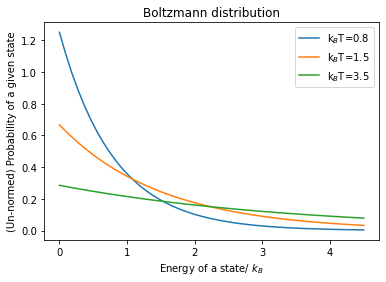

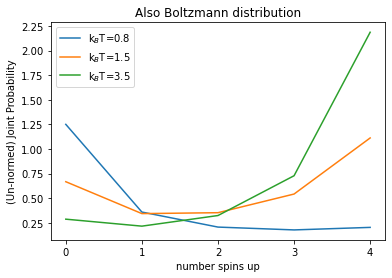

In [3]:
'''just some code to make a plot'''
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline


ax = plt.subplot(xlabel=r"Energy of a state/ $k_B$",\
                  ylabel="(Un-normed) Probability of a given state", title="Boltzmann distribution")
E = np.linspace(0, 4.5, num=50)
for i, T in enumerate([0.8, 1.5, 3.5]):
    ax.plot(E, 1.0/T*np.exp(-E/T), "-", label="k$_B$T={}".format(T))
ax.legend();
plt.show()
plt.cla()


ax = plt.subplot(xlabel=r"number spins up",\
                    ylabel="(Un-normed) Joint Probability", title="Also Boltzmann distribution")
n_up = np.arange(5, dtype=int)
nfac = np.copy(n_up)
for i in range(len(nfac)):
    nfac[i] = math.factorial(nfac[i])
for i, T in enumerate([0.8, 1.5, 3.5]):
    p  = 1.0/T*np.exp(-n_up/T)
    p *= nfac
    ax.plot(n_up, p, "-", label="k$_B$T={}".format(T))
ax.set_xticks(n_up)
ax.legend();

Above is just a plot of the Boltzmann distribution: the hotter the system, the more likely that it will excite to higher-energy states.  The key here is that there are **only two ground states** (all-up and all-down), whereas for any single-spin excitation (eg all-except-one up) there are $N$ available states, so for any finite temperature it will become highly unlikely that the system genuinely is in its energy minimium: the minima are the most likely two given microstates, but the number of non-minimum microstates is hugely larger, so non-minimum microstates dominate.  The competition here is between an exponential (the Boltzmann factor above) and a factorial (lets look at the combinations: one excitation has $N$ allowed positions.  Two excitations can be in $N(N-1)$, three get $N^3+...$ etc).  The above plots are extremely rough, meant only to convey the general idea that energy is not everything, the **degeneracy**, the number of states that we will treat as equivalent, also matters.




To see interesting behaviour we may need to go to large N so I will provide what I hope is an efficient implementation of the Ising model below.

H at start: 0.02


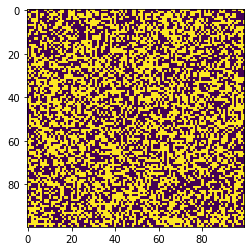

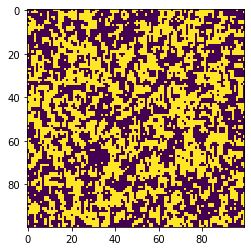

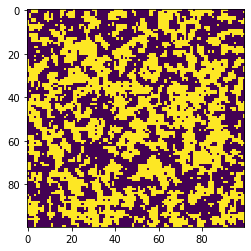

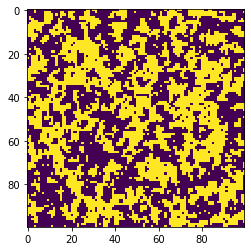

H now: -0.50


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import math, random
%matplotlib inline

class Ising:
    """Attempt by JTB at an efficient Ising model in python.
    
    The main optimisation is to use 16-bit integers for the spins, so more can be held in cache.
    
    Also attempted to make a pythonic approach to the Monte-Carlo update of spin states:
    Random numbers and as much maths as possible are generated outside the loop, 
    to minimise number of expensive python-level function calls.
         
    Spins to flip are not selected at random but swept in such a way that the order doesn't matter.
    """
    
    
    def __init__( self, L, T = 1. ):
        self.L = L
        self.N = L*L
        self.T = T
        self.s = np.random.randint(0,2,size=(L,L),dtype='int16') * 2 - 1
        self.ene = self.H()    
            
    ##calculate total system energy: only need this once.
    def H( self ):
        ene = 0.
        for i in range(self.L):
            for j in range(self.L):
                ene -= self.s[i,j]*(self.s[(i+1)%self.L,j] + self.s[i, (j+1)%self.L])
        return ene
    
    
    ##Update spins according to thermal fluctuations
    ##following the Boltzmann distribution
    ##
    ## we make two sweeps following black and then white squares
    ## of a chessboard, because this way
    ## the update order doesn't matter (much).
    def boltzUpdate_simple(self):
        """Simple easy-to-read code for Monte Carlo update respecting the Boltzmann distribution."""
        for i in range(0, self.L):
            for j in range(i%2, self.L, 2):
                e0 = self.H()
                self.s[i,j] *= -1
                deltaE = self.H() - e0
                if np.random.random() < np.exp(-deltaE / self.T):
                    self.ene += deltaE
                    continue      ##accept the flip 
                self.s[i,j] *= -1 ##reject the flip
                
        for i in range(0, self.L):
            for j in range(1+i%2, self.L, 2):
                e0 = self.H()
                self.s[i,j] *= -1
                deltaE = self.H() - e0
                if np.random.random() < np.exp(-deltaE / self.T):
                    self.ene += deltaE
                    continue      ##accept the flip 
                self.s[i,j] *= -1 ##reject the flip
            
    def boltzUpdate_opt(self):
        """Try to make a faster update code by vectorising rng calls,
        and by getting rid of full-system energy evals other than at startup."""
        
        T_log_rnd = self.T * np.log( np.random.random((self.L, self.L)) )
        L         = self.L
        
        for i in range(0, L):
            for j in range(0, L, 2):
                deltaE = self.s[i,j] *\
                          ( self.s[(i+1)%L,j] +\
                            self.s[i-1,    j] +\
                            self.s[i,(j+1)%L] +\
                            self.s[i,j-1] )
                
                if T_log_rnd[i,j] < -deltaE:
                    ##accept the flip 
                    self.s[i,j] *= -1
                    self.ene += deltaE
                    
        ##flip black squares of chessboard
        for i in range(0, L):
            for j in range(1+i%2, L, 2):
                deltaE = self.s[i,j] *\
                          ( self.s[(i+1)%L,j] +\
                            self.s[i-1,    j] +\
                            self.s[i,(j+1)%L] +\
                            self.s[i,j-1] )
                if T_log_rnd[i,j] < -deltaE:
                    ##accept the flip 
                    self.s[i,j] *= -1
                    self.ene += deltaE 
                    
        ##this update scheme is called a "red-black decomposition"
        ##because someone had a red and black chessboard I guess.
            
    def show( self ):
        plt.imshow(self.s, interpolation='none', vmin=-1., vmax=1.)
        plt.show()
        
###test the code:
I = Ising(100)
print("H at start: %.2f" % (I.ene/I.N))
I.show()
#I.boltzUpdate_simple()
#I.show()

I.boltzUpdate_opt()
I.show()
I.boltzUpdate_opt()
I.show()
I.boltzUpdate_opt()
I.boltzUpdate_opt()
I.boltzUpdate_opt()
I.boltzUpdate_opt()
I.boltzUpdate_opt()
I.boltzUpdate_opt()
I.boltzUpdate_opt()
I.boltzUpdate_opt()
I.show()
print("H now: %.2f" % (I.ene/I.N))
            

At $T=1$, $J=1$ (for the above test), the system forms magnetic domains starting from a random configuration. Over time the size of the domains grow ("*coarsening*") until the one domain dominates the whole system.  Coarsening slows down as the domains get bigger: the energy cost to have a spin boundary is related to the curvature of the boundary, so larger domains see weaker statistical forces. 

Below, lets try with all spins initialised up:


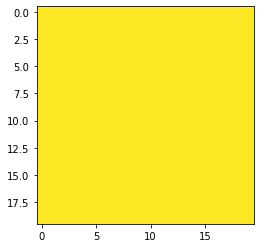

H now: -2.00


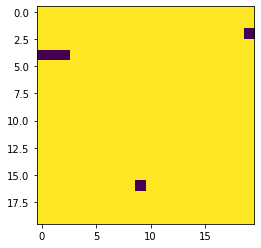

H now: -1.92


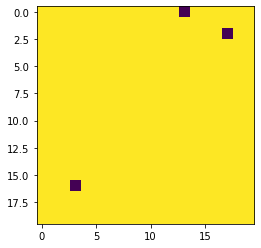

H now: -1.94


In [12]:
I     = Ising(20)
I.s   = np.ones_like(I.s)
I.ene = I.H()
I.T   = 1.

I.show()
I.ene = I.H()
print("H now: %.2f" % (I.ene/I.N))

I.boltzUpdate_opt()
I.show()
I.ene = I.H()
print("H now: %.2f" % (I.ene/I.N))

I.boltzUpdate_opt()
I.show()
I.ene = I.H()
print("H now: %.2f" % (I.ene/I.N))
            

OK: for a small system at $T=1$ the all-up state is stable, however for a large system there will always be some fluctuations away from the all-up state going on somewhere.  Even for the small system, after some large finite time the whole system should flip to the opposite alignment or to a jammed mixed state.

What about for large $T$?


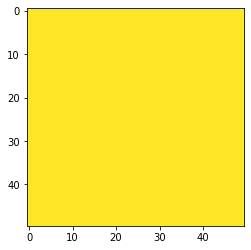

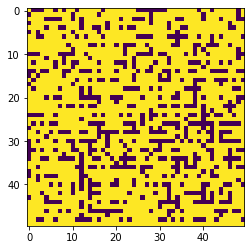

In [16]:
I = Ising(50)
I.s = np.ones_like(I.s)
I.T = 5
I.show()
for i in range(1000):
    I.boltzUpdate_opt()
I.show()


## Energy, heat capacity and phase transitions

We see above that at large $T$ the magnetisation loses its long-range order: this is a "melting" phase transition.  An analytical result (from Onsager) fixes this critical temperature (the Curie temperature) at $T_c=2/\ln (1+\sqrt{2})$ in the limit of an infinite system.  For smaller systems this temperaure is shifted.  Close to $T_c$ we expect to see coexistence of order and disorder.

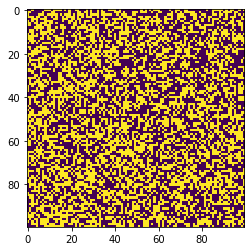

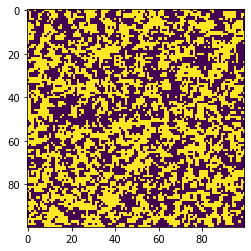

The system shows some structure and also some randomness


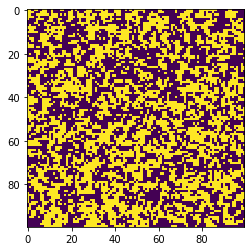

fluctuations are significant and may be quite fast
clouds in the sky are an example of systems close to the critical temperature for a phase transition


In [14]:
I = Ising(100, T=2./np.log(1+np.sqrt(2)))
I.show()
for i in range(100):
    I.boltzUpdate_opt()
I.show()
print("The system shows some structure and also some randomness")
for i in range(100):
    I.boltzUpdate_opt()
I.show()
print("fluctuations are significant and may be quite fast")


print("clouds in the sky are an example of systems close to the critical temperature for a phase transition")


To quantify thermal response we can define the **heat capacity** $c_V$ of the system. 

One way to define $c_V$ is as the derivative temperature by energy. The other is via the variance of the (scaled by N) energy at constant $T$, which it is convenient to collect without having to run separate simuations at different temperatures:

$$c_V = \frac{1}{N}\frac{d<E>}{dT} = \frac{1}{NT^2}\langle (E - \langle E\rangle)^2\rangle$$

At a first order phase transition the value of $c_v$ should diverge, because a small increase in temperature leads to a dramatic reorganisation and shift in the energy-entropy balance of the system (such as melting or freezing).


# ASSIGNMENT

Calculate $c_v$ over a range of temperatures crossing $T_c$.  Lets say $T=(0.6,.8,1.0,1.2...1.8)T_c$.  The variance-based formula is probably the easiest to implement correctly.  Also collect and plot the data $<E>(T)/N$.

**TIPS**: before you can collect data, you will need to allow a few updates for the system to stabilise.  I find about 1000 is the minimum.  To collect well-converged results for the whole parameter range takes >5 minutes on my laptop, so it should be worthwhile to make test runs looking at small systems only.  Consider plotting the time series of energies for each run to sanity-check your output and make sure that each system is converging.  Don't always create a complete new system for each temperature: just change the temperature of the previous system at that size.  That way you can hope to be closer to the correct behaviour at the start of each run than if you started from a random new system.

Repeat your calculation for three system sizes, $L=20$, $L=30$, $L=40$.  Plot the $c_v$ curves together on the same axis.   

Write down physically motivated explanations for the feature(s) of the three curves and the differences that you observe between them.   Obviously $L$ is having an effect here, but why? If there is anything odd or unexpected in any of your curves, explain it.

When you have finished, upload your assignment.  As usual it will count towards your final mark.


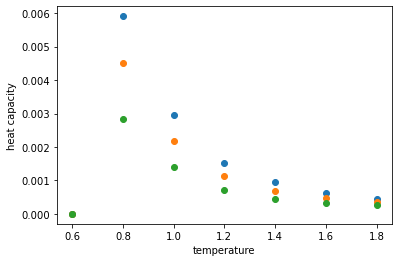

In [98]:
## average calculator
def avgCalculator(L):
    N = len(L)
    avg = 0
    for i in range(N):
        avg += L[i]
    avg /= N
    return avg

## variance calculator
def varCalculator(L):
    N = len(L)
    var = 0
    avg = avgCalculator(L)
    for i in range(N):
        var += (L[i]-avg)**2
    var /= N
    return var

def heatCapacity(L,T,N):
    capacity = varCalculator(L)
    capacity /= (N*T**2)
    return capacity

energy = []
capacity = []
tempList = []
for i in range(6,20,2):
    tempList.append(i/10)
    
for i in range(2,5):
    
    N = i*10
    I = Ising(N)
    
    for i in range(6,20,2):
        T = i/10
        I.T = T
        I.ene = I.H()
        for i in range(100):
            I.boltzUpdate_opt()
        energy.append(I.ene/I.N)
        capacity.append(heatCapacity(energy, T, N))
    energy = []


plt.scatter(tempList, capacity[0:7],label = "N = 20")
plt.scatter(tempList, capacity[7:14],label = "N = 30")
plt.scatter(tempList, capacity[14:21],label = "N = 40")
plt.xlabel("temperature")
plt.ylabel("heat capacity")
plt.show()

## Observations
We can observe that the heat capacitance diminishes as the temperature rises, as expected from the formula. Howver, we also notice that the bigger the L, the lower the heat capacitance actually is. As seen in the lecture part, it looks like the lattice is more 'chaotic' for large L, but if we zoom in, the individual subsections don't change that much (thus smaller L). It is as if we were looking at smaller systems, that are therefore more stable, or rather, where chaos isn't so impactful.